<a href="https://colab.research.google.com/github/ISL-0111/XAI_AIPI590.01_2025Fall/blob/main/Week3_Interpretable_ML_Assignment_Ilseop(Shawn)Lee_in_process_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instructions
In this assignment, you will work with a dataset from a telecommunications company (https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code). The company is interested in understanding the factors that contribute to customer churn (customers leaving the company for a competitor) and developing interpretable models to predict which customers are at risk of churning.

#### Tasks

1. Exploratory Data Analysis to check Assumptions: Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn). Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met.
2. Linear Regression: Treat the churn variable as a continuous variable (e.g., 0 for staying, 1 for churning) and build a linear regression model to predict churn. Interpret the coefficients and assess the model's performance.
3. Logistic Regression: Treat churn as a binary variable and build a logistic regression model to predict the probability of churn. Interpret the coefficients.
4. Generalized Additive Model (GAM): Build a GAM to model the non-linear relationships between customer features and churn. Interpret the GAM model.
5. Model Comparison: Compare the performance and interpretability of the different models you built. Discuss the strengths and weaknesses of each approach and provide recommendations for which model(s) the telecommunications company should use to address their customer churn problem.


Rubric
- Notebook is well documented and includes details and references to the dataset and models used Assumptions are evaluated with exploratory data analysis and explained in markdown inside the notebook
- Code implementing the linear regression model is correct
- Code implementing the linear regression model is clear and well documented
- Linear regression model is interpreted appropriately and interpretation is discussed in markdown
- Code implementing the logistic regression model is correct
- Code implementing the logistic regression model is clear and well documented
- Logistic regression model is interpreted appropriately and interpretation is discussed in markdown
- Code implementing the GAM is correct
- Code implementing the GAM is clear and well documented
- GAM is interpreted appropriately and interpretation is discussed in markdown
- A discussion of the strengths and weaknesses of each approach is included in markdown
- Recommendations for which model(s) the telecommunications company should use to address their customer churn problem are provided and explained in markdown

In [2]:
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pygam import LogisticGAM, l, s
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    classification_report,
    f1_score,
    log_loss,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.tools.sm_exceptions import PerfectSeparationError

### 1. Exploratory Data Analysis to check Assumptions

#### Data Preparation
- Loaded the Telco Customer Churn dataset and performed sanity checks.
- Converted `TotalCharges` from object to numeric value and found 11 missing values.
- Assumed that missing values corresponds to new customers(`tenure` == 0) who have not been billed yet ⇒ Imputed these with '0'
- Target variable is `Churn`(Yes or No) and others(`gender` ~ `TotalCharges`) are predictor variables
- Among predictor variables,`tenure`, `MonthlyCharges`, `TotalCharges` are continous, while the rest are categorical.
- Verified the 7,043 unique `customersID` with no duplicates.

In [3]:
url = "https://raw.githubusercontent.com/ISL-0111/XAI_AIPI590.01_2025Fall/main/Week3_Interpretable_ML_Assignment/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)

# data types check & missing values check
display(df.head(3))
df.info()

# Total charge is object, should be numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Total charges has 11 missing values
missing_counts = df.isna().sum().sort_values(ascending=False)
print(missing_counts[missing_counts > 0])

# N/A in TotalCharges should be '0' (I assume they are new customers)
mask_ten0 = (df["tenure"] == 0) & (df["TotalCharges"].isna())
df.loc[mask_ten0, "TotalCharges"] = 0

unique_customers = df['customerID'].nunique()  # 7043 unique customers
print(f"Number of unique CustomerID: {unique_customers}")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Exploratory Data Analysis and Assumption Checklists

- To select a suitable model for the given tasks, I verified necessary assumptions as below:
    - Pre-model (EDA): Assess whether the **data itself** is likely to satisfy required assumptions (e.g., linearity in scatterplots, class balance)
    - Post-model: After fitting, check whether the **model fit** actually satisfies assumptions (e.g., residual patterns)

- In this assignment, I compare `Linear Regression`, `Logistic Regression`, and `Generalized Additive Model(GAM)`. The checklist are as follows.<bf>

    (1) Linear Regression:<bf>
    - Pre-Model (EDA)
        - Linearity(rough): Scatterplots of continuous variables<bf>
        - No multicollinearity(rough): Correlation matrix heatmap<bf>
    - Post-Model<bf>
        - Linearity & Correct specification: Partial residual plots
        - Normality of residuals: Normal Q-Q plot
        - Homoscedasticity: Scale-Location Plot
        - No influential outliers: Residuals vs leverage plot with Cook's distance
        - No multicollinearity: VIF

    (2) Logistic Regression:
    - Pre-Model (EDA)
        - Large sample size: (N=7,043)
        - Independence of observation: unique `CustomerID` equals total rows
    - Post-Model
        - Perfect separation: Explicit check
        - Linearity in the logit: Box-Tidwell
        - No influential outliers : Logistic residuals vs leverage plot with Cook's distance
        - No multicollinearity: Same as (1)Linear Regression

    (3) Generalized Additive Model(GAM):
    - Pre-Model (EDA)
        - Nonlinearity: Already covered in (1)Correct specification(Partial residual plots)
    - Post-Model
        - Additivity : GAM summary (additive terms shown)
        - Perfect Separation: Explicit check
        - Smoothness of splines: Partial Dependence Plots
        - Correct link function: GAM summary
        - No multicollinearity: Same as (1)Linear Regression


**Exploratory Data Analysis result**

The pre-model assumption checks for all three models were conducted through a common EDA of the given dataset. Key findings are below.

(1) Linear Regression:<bf>
- **Linearity(rough)**: Scatterplots and by-churn distributions of the continuous variables showed strong `nonlinear` pattern with `tenure`<bf>
- **No multicollinearity(rough)**: correlation matrix heatmap shows *tenure–TotalCharges ≈ 0.83, MonthlyCharges–TotalCharges ≈ 0.65, tenure–MonthlyCharges ≈ 0.25*. This implies high collinearity risk if those variables are included together. This will confirmed with VIF after modeling. *(Note: This assingment does not require to treat collinearity. Therefore, I will keep the values)*

(2) Logistic Regression:
- **Large sample size**: The dataset has 7,043 observations. With 1,869 churn cases and 19 predictors, EPV of around 98 surpasses the recommend minimum of 10.
- **Independence of observation**: During the data preparation stage, I verified that the number of unique `CustomerID` equals the number of rows, supporting independence assumption.

(3) Generalized Additive Model(GAM):
- **Nonlinearity**: The distributions and pairwise plots of continuous variables suggest `nonlinear` effects as stated above. I will further verify this after the linear model via partial residual plots

/tmp/ipython-input-3149178436.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Churn", palette="Set1")


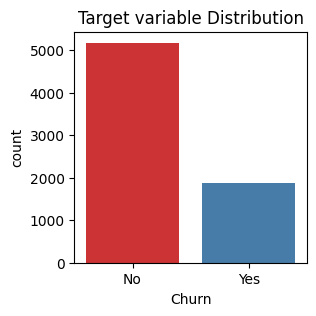

Churn distribution (%):
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [4]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x="Churn", palette="Set1")
plt.title("Target variable Distribution")
plt.show()

churn_counts = df["Churn"].value_counts(normalize=True) * 100
print("Churn distribution (%):")
print(churn_counts)

/tmp/ipython-input-3082900924.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="tenure", data=df, ax=axes[1, 0], palette="pastel")
/tmp/ipython-input-3082900924.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="MonthlyCharges", data=df, ax=axes[1, 1], palette="pastel")


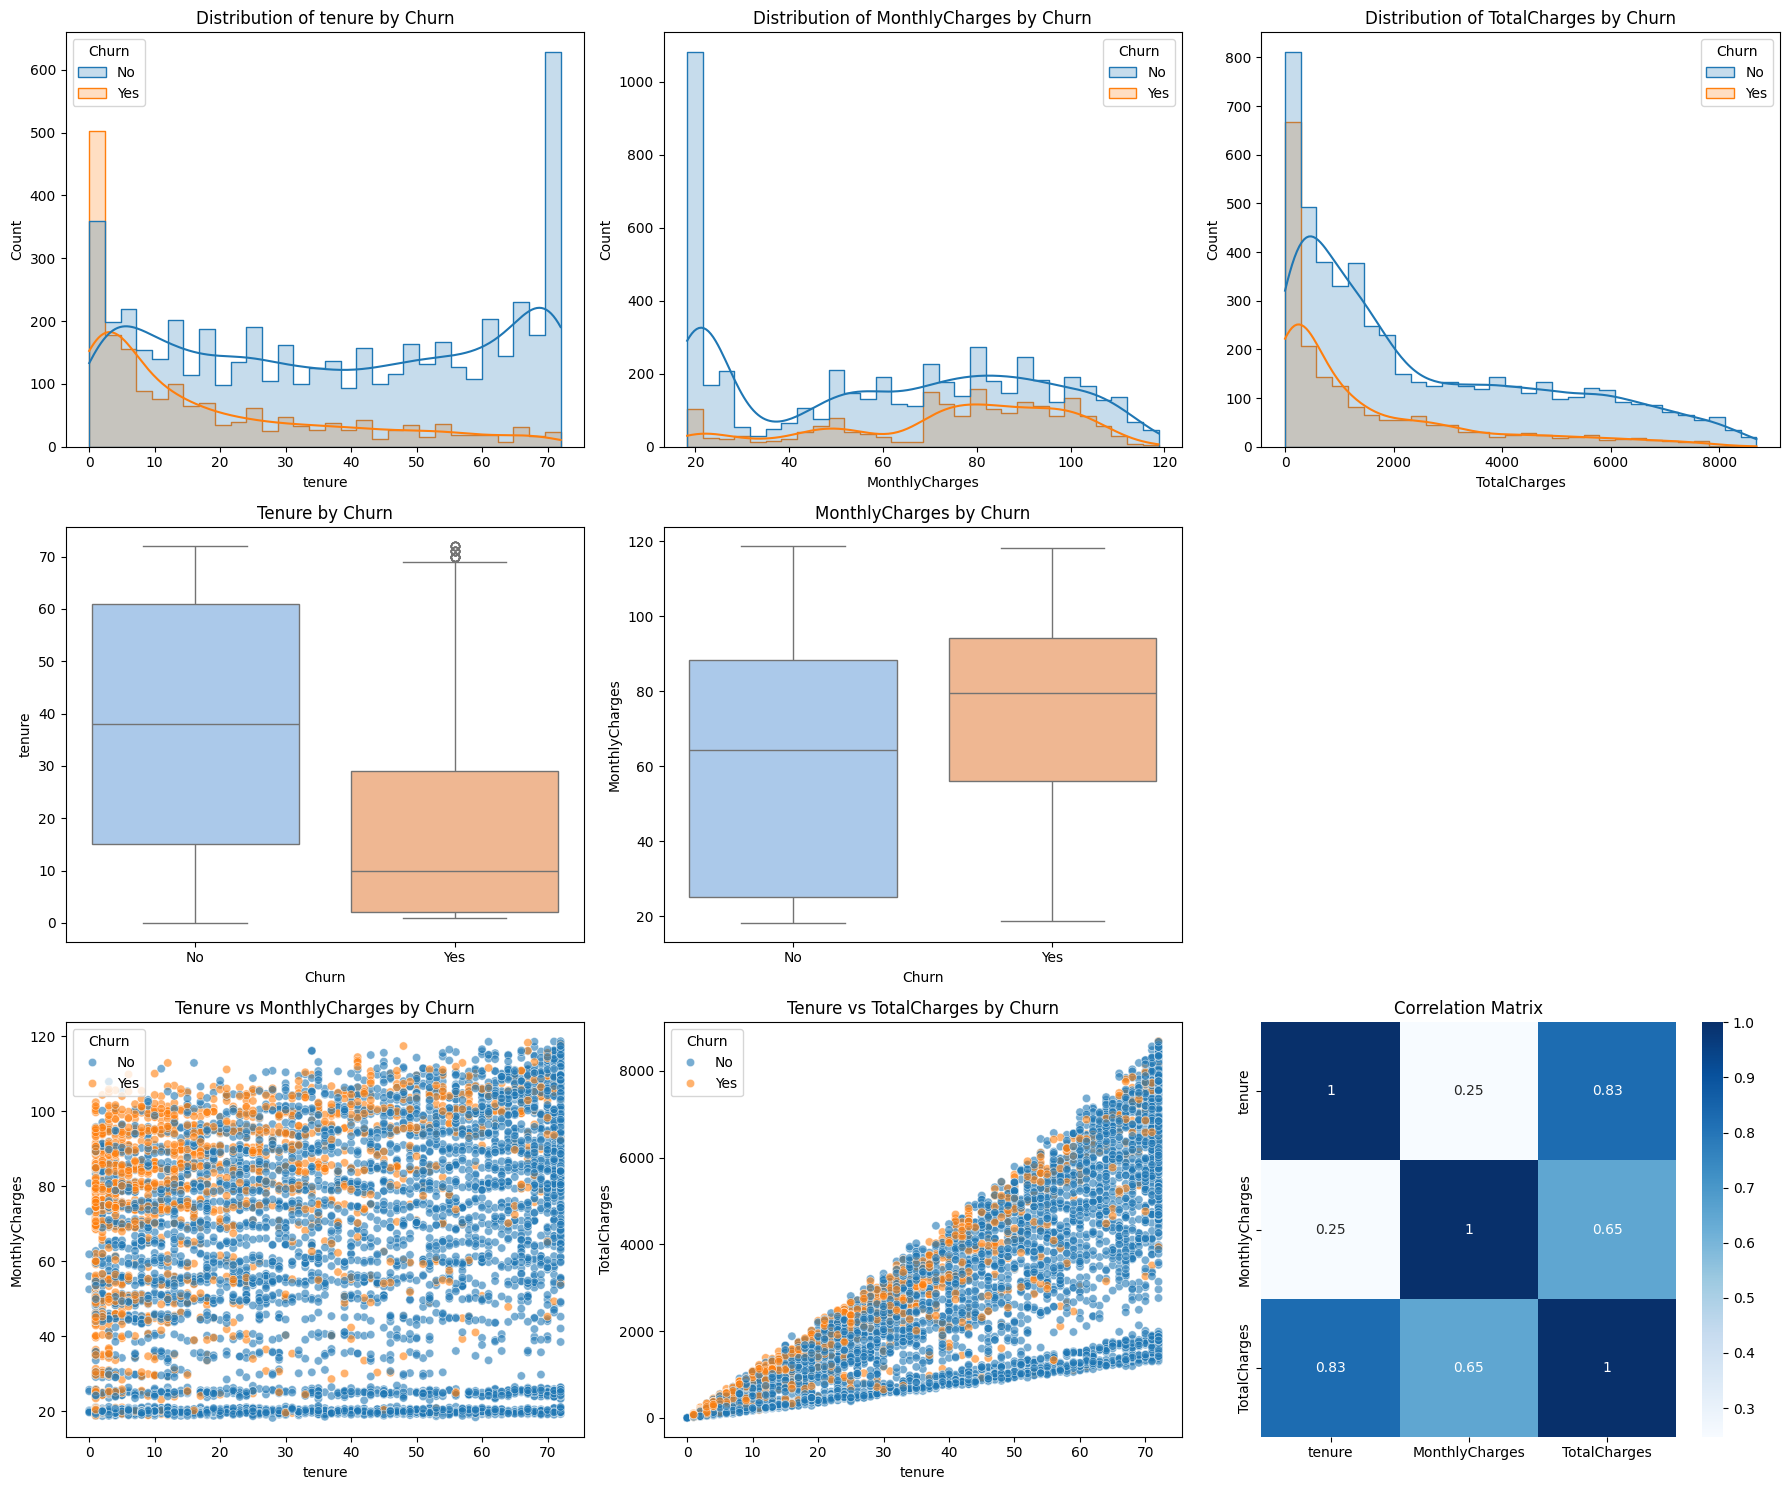

In [5]:
# Continuous variables
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Histograms
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue="Churn", bins=30, kde=True, ax=axes[0, i], element="step", stat="count", common_norm=False)
    axes[0, i].set_title(f"Distribution of {col} by Churn")

# Boxplots
sns.boxplot(x="Churn", y="tenure", data=df, ax=axes[1, 0], palette="pastel")
axes[1, 0].set_title("Tenure by Churn")
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, ax=axes[1, 1], palette="pastel")
axes[1, 1].set_title("MonthlyCharges by Churn")
axes[1, 2].axis("off")

# Scatterplots
sns.scatterplot(data=df, x="tenure", y="MonthlyCharges", hue="Churn", alpha=0.6, ax=axes[2,0])
axes[2,0].set_title("Tenure vs MonthlyCharges by Churn")
sns.scatterplot(data=df, x="tenure", y="TotalCharges", hue="Churn", alpha=0.6, ax=axes[2,1])
axes[2,1].set_title("Tenure vs TotalCharges by Churn")

# Correlation
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="Blues", ax=axes[2,2])
axes[2,2].set_title("Correlation Matrix")

plt.tight_layout()
plt.show()

The goal of this assignment is model interpretation and comparison. Therefore, I do not perform feature engineering for improving model performance. As part of EDA, I visualized the current categorical variables to obtain high-level insights (e.g., potential level merges or interactions).

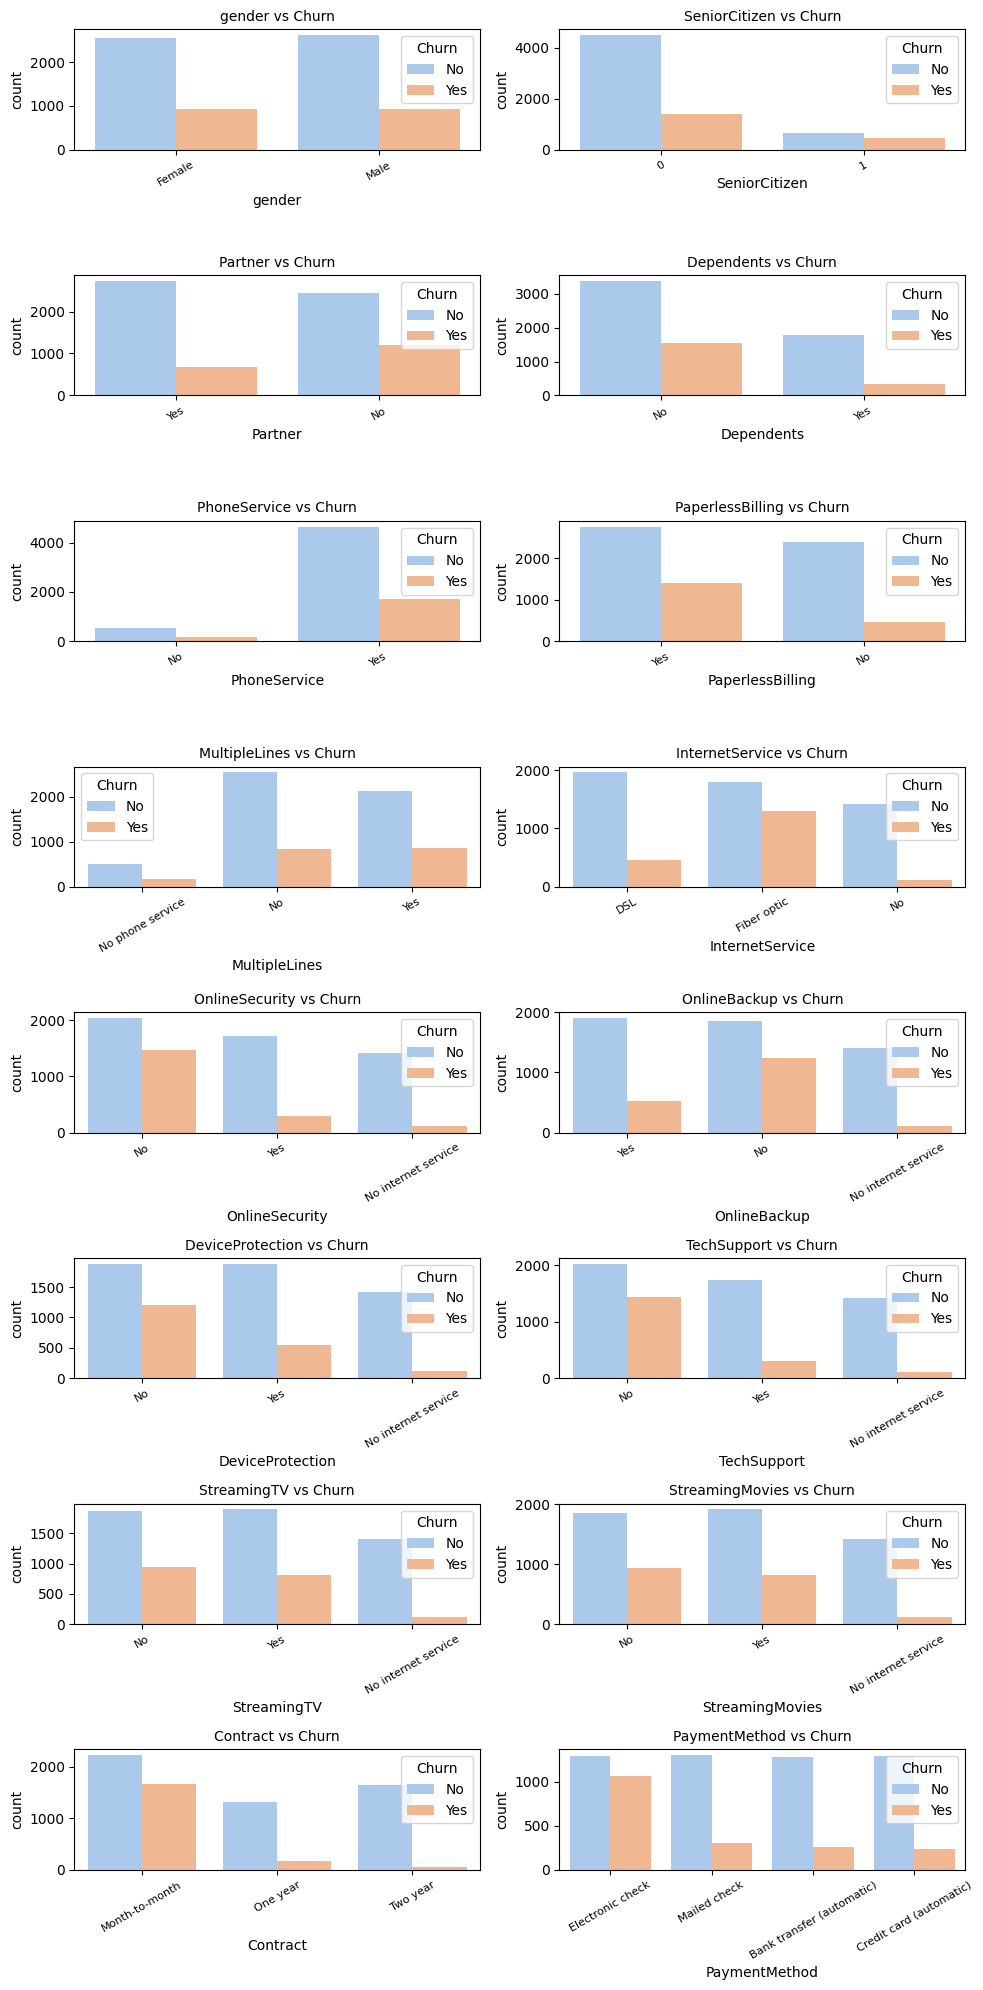

In [6]:
# Categorical variables
cat_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling",
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaymentMethod"
]

fig, axes = plt.subplots(8, 2, figsize=(10, 20))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, hue="Churn", ax=axes[i], palette="pastel")
    axes[i].set_title(f"{col} vs Churn", fontsize=10)
    axes[i].tick_params(axis="x", rotation=30, labelsize=8)

plt.tight_layout()
plt.show()

#### Data Processing for modeling
- Began model fitting to enable post-model assumption checks; only minimal cleaning and pre-processing were performed.
- Dropped identifiers(`CustomerID`) and encoded the target (Churn: No→0, Yes→1).
- Encoded categoricals: mapped binary strings and one-hot encoded multi-category features
- No feature engineering is applied to ensure all three models use the same feature set under the same conditions.
- Stratified 80/20 split with a fixed seed (random_state=42) for reproducibility
- Standardized only the continuous features (`tenure`, `MonthlyCharges`, `TotalCharges`) using training-set mean/std and applied that transform to the test set to prevent leakage(one-hot/binary features were not scaled).
- No sklearn Pipeline is used, but we enforce the same rule—fit preprocessing on train, apply to test—to keep training numerically stable and model comparisons fair and reproducible.

In [7]:
# Delete unnecessary columns
df = df.drop(columns=["customerID"])

# Target Variable encoding
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1}).astype(int)

# Binary Variable encoding (No, Yes)
binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
for col in binary_cols:
    df[col] = df[col].map({"No": 0, "Yes": 1}).astype("Int64")

# Binary Variable encoding (Female, Male)
df["gender"] = df["gender"].map({"Female": 0, "Male": 1}).astype("Int64")

# Multi-category Variable One-hot encoding
multi_cat = [
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"
]

df_final = pd.get_dummies(df, columns=multi_cat, drop_first=True)
df_final.head(3)

# Features / Target
X = df_final.drop(columns=["Churn"])
y = df_final["Churn"]

# Train/Test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Scaling
cont_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Keep DataFrames with column names
X_train_scaled_df = X_train.copy()
X_test_scaled_df  = X_test.copy()

# Fit scaler on TRAIN continuous columns only, transform both train & test
scaler = StandardScaler()
X_train_scaled_df[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_test_scaled_df[cont_cols]  = scaler.transform(X_test[cont_cols])

# If some downstream code expects numpy arrays:
X_train_scaled = X_train_scaled_df.values
X_test_scaled  = X_test_scaled_df.values

# Quick sanity check (only continuous cols should be ~ (0,1) on train)
print("Train continuous means after scaling:", X_train_scaled_df[cont_cols].mean().round(3).to_dict())
print("Train continuous stds  after scaling:", X_train_scaled_df[cont_cols].std().round(3).to_dict())

Train shape: (5634, 30)
Test shape: (1409, 30)
Train continuous means after scaling: {'tenure': -0.0, 'MonthlyCharges': -0.0, 'TotalCharges': 0.0}
Train continuous stds  after scaling: {'tenure': 1.0, 'MonthlyCharges': 1.0, 'TotalCharges': 1.0}


#### 2. Linear Regression
- Although Churn is binary, I treatted 0/1 as continuous to provide a simple, interpretable baseline.

- Fit OLS on the prepared design matrix and store predictions/metrics for the later model-comparison section.

- Run post-model diagnostics in the following order to assess whether linear-model assumptions are reasonable for this dataset:
    - Linearity & Correct specification(Partial residual plots)<bf>
    - Normality of residuals(Normal Q–Q)<bf>
    - Homoscedasticity(Scale–Location)<bf>
    - Influential points(Residuals vs Leverage with Cook’s distance)<bf>
    - Multicollinearity(VIF)<bf>

**Model Fit**

In [8]:
# Use scaled data but wrap in DataFrame to keep feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

# Add constant with proper naming
X_sm = sm.add_constant(X_train_scaled_df.astype("float64"), has_constant="add")
y_sm = y_train.astype("float64")

ols = sm.OLS(y_sm, X_sm).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     99.09
Date:                Sun, 14 Sep 2025   Prob (F-statistic):               0.00
Time:                        19:21:01   Log-Likelihood:                -2428.0
No. Observations:                5634   AIC:                             4904.
Df Residuals:                    5610   BIC:                             5063.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

**Evaluation**
- Add a constant to the test set, generate predictions with the trained linear regression model, and compuse MSE and R^2 to report hold-out performance
- MSE=0.1440 → Mean squared error on the test set; lower is better
- R²=0.261 → The model explains about **26.1%** of the variance in the test targetss; this seems low

In [9]:
X_test_sm = sm.add_constant(X_test_scaled_df, has_constant="add")
y_pred_ols = ols.predict(X_test_sm)

mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols  = r2_score(y_test, y_pred_ols)

print(f"MSE={mse_ols:.4f}, R²={r2_ols:.3f}")

MSE=0.1440, R²=0.262


**Assumptions Evaluation (Post-Model)**

- **Linearity & Correct specification (Partial residual plots)**

    - Because the target is binary (0/1), a standard Residuals vs Fitted plot is not informative to check linearity. Instead, I used CCPR (component-plus-residual) plots to assess each continuous predictor’s functional form while controlling for the others.
    
    - `Tenure` appears roughly linear, but `MonthlyCharges` and `TotalCharges` show nonlinearity. Therefore, more flexible model(e.g., GAM) is better to capture the relationship in the given data.

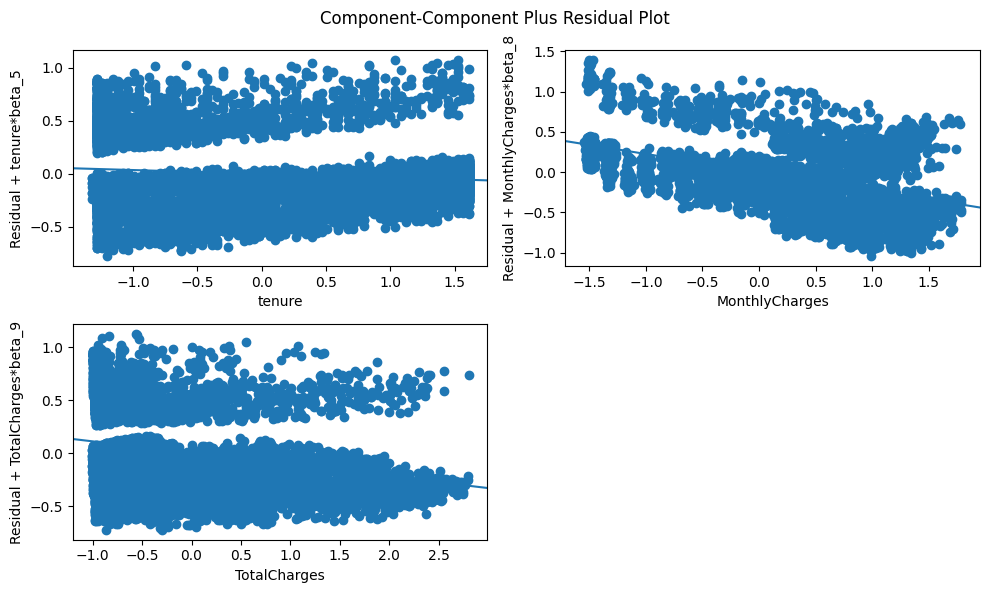

In [10]:
cont_features = ["tenure", "MonthlyCharges", "TotalCharges"]

fig = plt.figure(figsize=(10, 6))
sm.graphics.plot_ccpr_grid(ols, fig=fig, exog_idx=[ols.model.exog_names.index(c) for c in cont_features])
plt.tight_layout()
plt.show()

- **Normality of residuals(Normal Q–Q)**

    - The Q–Q plot checks whether residuals follow a normal distribution, which rationalizes standard OLS t-tests and confidence intervals.

    - The output forms an S-shape with clear departures from the 45° line in both tails, indicating non-normal residuals.
    
    - Because normality is violated, linear regression is less reliable, and the target is binary, Logistic Regression or a GAM is more appropriate

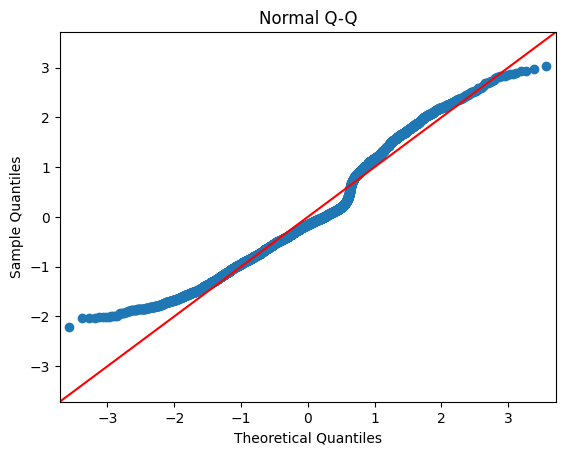

In [11]:
# Normal Q-Q
resid = ols.resid
sm.qqplot(resid, line='45', fit=True)
plt.title("Normal Q-Q")
plt.show()

- **Homoscedasticity(Scale–Location)**

    - The Scale–Location plot checks whether residuals have constant variance (homoscedasticity) across fitted values.

    - The output shows a curved, twisted pattern instead of a random horizontal spread, suggesting heteroscedasticity.

    - Because homoscedasticity is violated, the standard errors and test statistics from linear regression may be biased (Logistic Regression or GAM could be alternatives).

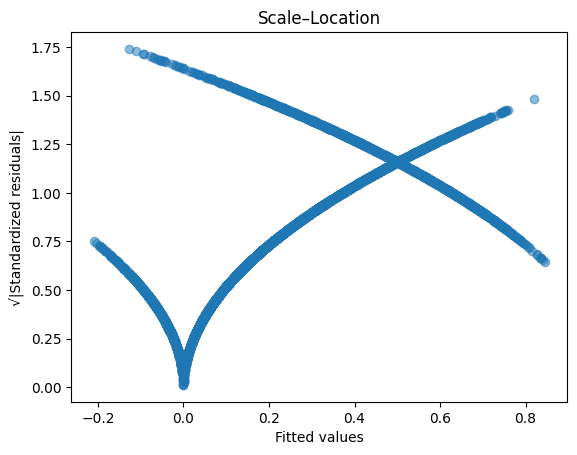

In [12]:
# Scale–Location
fitted = ols.fittedvalues
influence = ols.get_influence()
std_resid = influence.resid_studentized_internal
plt.scatter(fitted, np.sqrt(np.abs(std_resid)), alpha=0.5)
plt.title("Scale–Location")
plt.xlabel("Fitted values")
plt.ylabel("√|Standardized residuals|")
plt.show()

- **Influential points(Residuals vs Leverage with Cook’s distance)**

    - High-leverage points (to the right of the orange line) with large Cook’s D (red) can disproportionately influence regression coefficients.

    - Studentized residuals beyond ±3 indicate potential outliers with large prediction errors.

    - Most observations show low Cook’s D (blue), and only a few high-leverage, high-Cook’s D cases exist, so overall model influence from outliers is minimal.

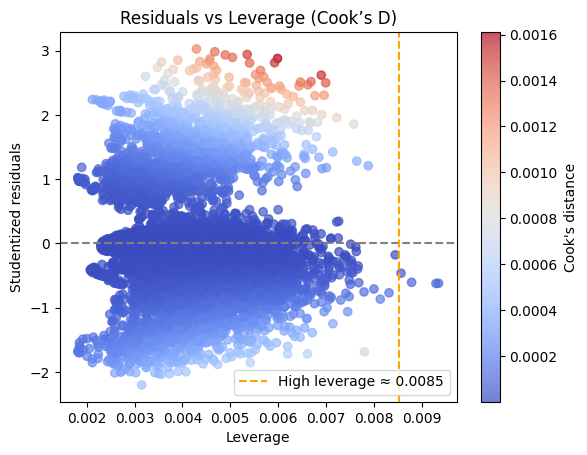

In [13]:
infl = OLSInfluence(ols)
leverage = infl.hat_matrix_diag
std_resid = infl.resid_studentized_internal
cooks_d = infl.cooks_distance[0]

n = len(y_train)
p = ols.df_model + 1
thr_high_lev = 2 * p / n

plt.scatter(leverage, std_resid, c=cooks_d, cmap="coolwarm", alpha=0.7)
plt.axhline(0, color='gray', ls='--')
plt.axvline(thr_high_lev, color='orange', ls='--', label=f"High leverage ≈ {thr_high_lev:.4f}")
plt.colorbar(label="Cook's distance")
plt.xlabel("Leverage")
plt.ylabel("Studentized residuals")
plt.title("Residuals vs Leverage (Cook’s D)")
plt.legend()
plt.show()

- **Multicollinearity(VIF)**<bf>

    - Several dummy variables (e.g., “No internet service”, “No phone service”) show infinite VIF, indicating very strong collinearity due to redundant information.

    - `MonthlyCharges` (≈861) and `InternetService_Fiber optic` (≈148) show extreme multicollinearity, largely explained by their correlation with `TotalCharges` and `tenure`.

    - Other predictors (e.g., streaming services) have VIF around 20–30, while demographic and contract/payment variables are stable (<2).

    - Severe multicollinearity reduces coefficient stability and interpretability. However, since the goal of this assignment is model comparison, regularization is not applied.

In [14]:
X_vif = pd.DataFrame(X_train_scaled, columns=X_train.columns).astype("float64")
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print(vif_data.sort_values(by="VIF", ascending=False))

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                  feature         VIF
13     OnlineSecurity_No internet service         inf
12                     InternetService_No         inf
19        TechSupport_No internet service         inf
21        StreamingTV_No internet service         inf
17   DeviceProtection_No internet service         inf
15       OnlineBackup_No internet service         inf
23    StreamingMovies_No internet service         inf
7                          MonthlyCharges  861.910805
5                            PhoneService  356.348855
9          MultipleLines_No phone service  152.357735
11            InternetService_Fiber optic  147.788143
22                        StreamingTV_Yes   24.033813
24                    StreamingMovies_Yes   24.014452
8                            TotalCharges   10.995172
4                                  tenure    7.641245
10                      MultipleLines_Yes    7.251165
18                   DeviceProtection_Yes    6.942107
16                       Onl

**Summary**

- Key Interpretations
    - Tenure (–): Longer customer tenure reduces churn risk.
    - SeniorCitizen (+): Seniors have slightly higher churn probability.
    - Fiber optic (+): Customers with fiber optic are more likely to churn (possibly due to pricing/quality issues).
    - Contract (–): One-year and two-year contracts strongly reduce churn.
    - Electronic check (+): Customers paying by electronic check are more likely to churn.

- Limitations of Linear Regression
    - Model fit is weak (low R^2 value). Therefore, churn cannot be well explained as a continuous outcome.
    - Severe multicollinearity results in coefficient signs and magnitudes are unreliable.
    - Linearity assumption is violated

- Implications
    - Linear regression provides exploratory insights but is not reliable for prediction.
    - Logistic regression is more appropriate for binary churn outcomes, and GAM might be able to capture nonlinear churn patterns better.

#### 3. Logistic Regression

- Since Churn is binary, Logistic Regression is a more appropriate model. It models the log-odds of churn and provides probability estimates interpretable for classification.

- Fit the logistic regression model on the prepared design matrix and store predictions/metrics for the later model-comparison section.

- Run post-model diagnostics in the following order to assess whether logistic regrssion model assumptions are reasonable for this dataset:

    - Perfect separation(Explicit check)<bf>

    - Linearity in the logit(Box-Tidwell)<bf>

    - No influential outliers(Logistic residuals vs leverage plot with Cook's distance)<bf>

    - No multicollinearity(Same as (1)Linear Regression)<bf>

**Model Fit**

In [15]:
# Initialize Logistic Regression (with balanced class weights for imbalance)
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

log_reg.fit(X_train_scaled_df, y_train)
y_train_pred = log_reg.predict(X_train_scaled_df)
y_test_pred  = log_reg.predict(X_test_scaled_df)
y_test_prob  = log_reg.predict_proba(X_test_scaled_df)[:, 1]

coef_df = pd.DataFrame({
    "feature": X_train_scaled_df.columns,
    "coef": log_reg.coef_[0],
    "odds_ratio": np.exp(log_reg.coef_[0])
}).sort_values(by="odds_ratio", ascending=False)

print(coef_df)


                                  feature      coef  odds_ratio
11            InternetService_Fiber optic  1.222352    3.395164
8                            TotalCharges  0.486541    1.626680
24                    StreamingMovies_Yes  0.420611    1.522892
28         PaymentMethod_Electronic check  0.402478    1.495526
22                        StreamingTV_Yes  0.395359    1.484917
6                        PaperlessBilling  0.336449    1.399967
10                      MultipleLines_Yes  0.324742    1.383673
1                           SeniorCitizen  0.153869    1.166338
29             PaymentMethod_Mailed check  0.052313    1.053705
18                   DeviceProtection_Yes  0.041152    1.042010
0                                  gender  0.030555    1.031027
2                                 Partner  0.018776    1.018953
27  PaymentMethod_Credit card (automatic) -0.000671    0.999329
16                       OnlineBackup_Yes -0.070675    0.931765
15       OnlineBackup_No internet servic

**Evaluation**

- Evaluated logistic regression on the test set using multiple classification metrics.

- Accuracy=0.738 → The model correctly classifies ~74% of customers.

- ROC AUC=0.842 → Strong ability to rank churners vs. non-churners.

- PR AUC=0.633 → Precision–recall tradeoff is moderate; class imbalance impacts precision.

- F1=0.614 → Balance of precision and recall for the churn class.

- Log Loss=0.496, Brier=0.169 → Probabilistic predictions are reasonably calibrated.

- Class-specific results: Non-churn precision is high (0.90), while churn recall is strong (0.78), indicating the model prioritizes detecting churners but at the cost of false positives.

Accuracy:   0.738
ROC AUC:    0.842
PR AUC:     0.633
F1 Score:   0.614
Log Loss:   0.496
Brier Score:0.169

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



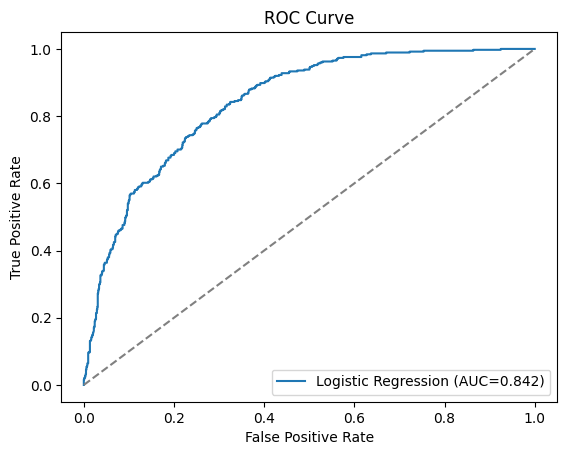

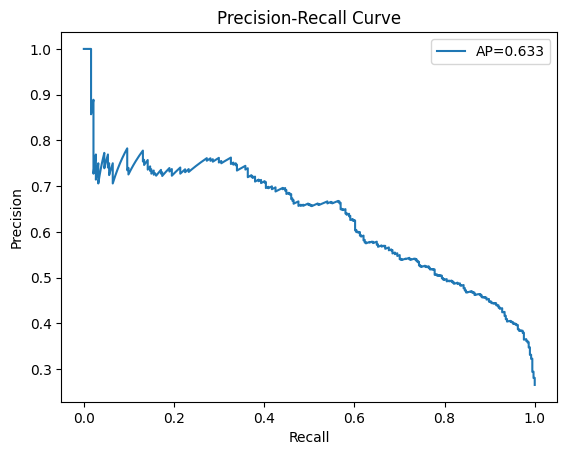

In [16]:
# --- Evaluation on Test Set ---
acc  = accuracy_score(y_test, y_test_pred)
roc  = roc_auc_score(y_test, y_test_prob)
pr   = average_precision_score(y_test, y_test_prob)
f1   = f1_score(y_test, y_test_pred)
ll   = log_loss(y_test, y_test_prob)
br   = brier_score_loss(y_test, y_test_prob)

print(f"Accuracy:   {acc:.3f}")
print(f"ROC AUC:    {roc:.3f}")
print(f"PR AUC:     {pr:.3f}")
print(f"F1 Score:   {f1:.3f}")
print(f"Log Loss:   {ll:.3f}")
print(f"Brier Score:{br:.3f}")

# --- Classification Report (optional) ---
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# --- Visualization: ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC={roc:.3f})")
plt.plot([0,1], [0,1], ls="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Visualization: Precision-Recall Curve ---
prec, rec, _ = precision_recall_curve(y_test, y_test_prob)
plt.plot(rec, prec, label=f"AP={pr:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


**Assumptions Evaluation (Post-Model)**

- **Perfect separation(Explicit check)**

    - Perfect separation occurs when a predictor (or category level) perfectly predicts churn (0% or 100% churn within a group).

    - The diagnostic shows no category/level with 0% or 100% churn for groups with n ≥ 10, so there is *no evidence* of perfect separation.

    - Logistic regression is therefore stable, and coefficients are not distorted by infinite estimates.

In [17]:
def check_perfect_separation(X, y, min_count=10):
    results = []
    for col in X.columns:
        mask = X[col] == 1
        n = mask.sum()
        if n < min_count:
            continue
        rate = y[mask].mean()
        if rate in (0.0, 1.0):
            results.append({
                "feature": col,
                "n_samples": int(n),
                "churn_rate": float(rate)
            })

    return pd.DataFrame(results)

extreme = check_perfect_separation(X_train_scaled_df, y_train)
if extreme.empty:
    print("No category with 0% or 100% churn (n ≥ 10).")
else:
    display(extreme)

No category with 0% or 100% churn (n ≥ 10).


**Linearity in the logit(Box-Tidwell)<bf>**

- The Box–Tidwell test evaluates whether continuous predictors enter the logit link function linearly, which is part of the broader notion of correct specification in logistic regression.

- For `tenure`, `MonthlyCharges`, and `TotalCharges`, the Box–Tidwell interaction terms are significant (p < 0.05), indicating violation of the linearity-in-logit assumption.

- This suggests the logistic model is misspecified, and a more flexible approach (e.g., GAM with splines) would be better suited to capture nonlinear effects.

In [18]:
def box_tidwell_test(X, y, vars_cont):
    results = []
    eps = 1e-6

    for var in vars_cont:
        x = pd.to_numeric(X[var], errors="coerce").astype(float) + eps
        X_bt = pd.DataFrame({var: x, f"{var}_log": x * np.log(x)})
        X_bt = sm.add_constant(X_bt, has_constant="add")

        model = sm.GLM(y, X_bt, family=sm.families.Binomial()).fit()
        pval = model.pvalues.get(f"{var}_log", np.nan)

        results.append({"variable": var, "p_X_log": pval,
                        "violated_(p<0.05)": pval < 0.05})

    return pd.DataFrame(results)

bt_results = box_tidwell_test(X_train, y_train, ["tenure", "MonthlyCharges", "TotalCharges"])
print(bt_results)

         variable       p_X_log  violated_(p<0.05)
0          tenure  2.329767e-05               True
1  MonthlyCharges  3.397907e-21               True
2    TotalCharges  2.675757e-10               True


**No influential outliers(Logistic residuals vs leverage plot with Cook's distance)<bf>**

- High-leverage points (to the right of the orange line) exist, but most have small Cook’s D values (blue), indicating limited influence on the model.

- A few observations with larger residuals and slightly elevated Cook’s D (red) are visible, but they are rare.

- Overall, most cases have low leverage and low Cook’s D, suggesting that outliers and influential points have minimal impact on the logistic regression model.

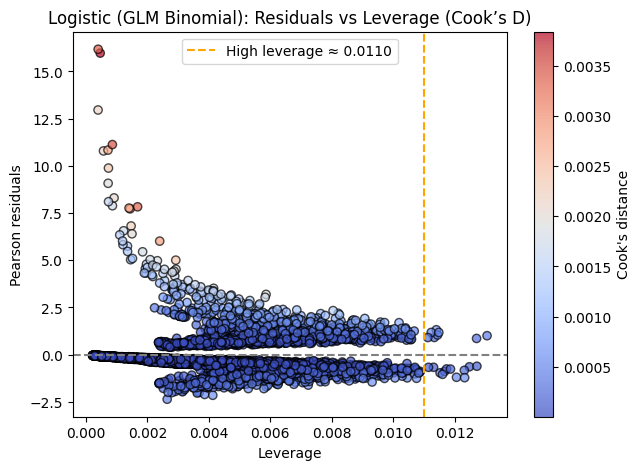

Outliers (|resid|>3): 88
High leverage (>0.0110): 20
Influential (Cook’s D > 0.0007): 196


In [19]:
y_bin = pd.to_numeric(y_train, errors="coerce").astype(float)
X_sm = sm.add_constant(X_train_scaled_df, has_constant="add").astype(float)
glm = sm.GLM(y_bin, X_sm, family=sm.families.Binomial()).fit()

infl = glm.get_influence()
pearson_resid = glm.resid_pearson
leverage = infl.hat_matrix_diag
cooks_d = infl.cooks_distance[0]

n, p = X_sm.shape
thr_high_lev = 2 * p / n

plt.figure(figsize=(7,5))
sc = plt.scatter(leverage, pearson_resid, c=cooks_d, cmap="coolwarm",
                 edgecolor="k", alpha=0.7)
plt.axhline(0, color="gray", ls="--")
plt.axvline(thr_high_lev, color="orange", ls="--", label=f"High leverage ≈ {thr_high_lev:.4f}")
plt.colorbar(sc, label="Cook's distance")
plt.xlabel("Leverage"); plt.ylabel("Pearson residuals")
plt.title("Logistic (GLM Binomial): Residuals vs Leverage (Cook’s D)")
plt.legend()
plt.show()

# 7) Flag points
outlier_idx = np.where(np.abs(pearson_resid) > 3)[0]
high_lev_idx = np.where(leverage > thr_high_lev)[0]
influential_idx = np.where(cooks_d > 4/n)[0]

print(f"Outliers (|resid|>3): {len(outlier_idx)}")
print(f"High leverage (>{thr_high_lev:.4f}): {len(high_lev_idx)}")
print(f"Influential (Cook’s D > {4/n:.4f}): {len(influential_idx)}")

**No multicollinearity(Same as (1)Linear Regression)<bf>**

- Multicollinearity detected in the linear regression also exists in the logistic regression, making coefficient estimates unstable.

- The dataset already showed severe collinearity, and this applies to both models.

- The difference lies in interpretation:
    - In Linear Regression, both R² and coefficient interpretation are distorted.
    - In Logistic Regression, predictive performance (AUC, Accuracy) can remain stable, but coefficient interpretation is still unreliable.

**Summary**

- Key Interpretations
    - Odds ratios(OR) offer more intuitive interpretability than linear regression coefficients, because it expresses how the odds of churn change multiplicatively for each predictor.
        - linear regression coefficients describe changes in a continuous outcome (churn probability treated as numeric), which is less meaningful in a binary churn setting.
    - Tenure (OR = 0.31): Longer customer tenure substantially reduces churn risk.
    - Contract (One-/Two-year, OR < 0.5): Longer contracts strongly protect against churn.
    - InternetService: Fiber optic (OR = 3.40): Fiber optic customers are over three times more likely to churn, possibly due to price or service quality issues.
    - Electronic check (OR = 1.50): Customers paying by electronic check have a higher churn risk.
    - Streaming services (OR ≈ 1.5): Subscriptions to StreamingTV/Movies show elevated churn likelihood.

- Limitations of logistic regression
    - Multicollinearity is severe (as seen in linear regression), making coefficients unstable.
    - Linearity-in-logit is violated (failed the Box–Tidwell test.)
    - Influential points exist but do not badly damaged model fit.

- Implications
    - Logistic regression performs better than linear regression for churn (ROC AUC = 0.842 vs. weak R² in OLS).
    - However, assumption violations (nonlinearity + multicollinearity) limit coefficient reliability.
    - Generalized Additive Models (GAM) can flexibly model nonlinear churn patterns

#### 4. Generalized Additive Model

- Since churn is binary, GAM is fit using a logistic link function. This allows flexible nonlinear effects of continuous variables while still modeling the log-odds of churn.

- Unlike Logistic Regression, GAM replaces strict linearity with smooth spline terms. Therefore, the model is able to capture nonlinear churn patterns

- The fitted GAM model provides probability estimates, which remain interpretable for classification, but also retains odds ratio–like interpretability for categorical variables.

- Run post-model diagnostics in the following order to assess whether GAM assumptions are reasonable for this dataset:
    - Additivity(Additive terms in GAM summary)
    - Perfect Separation(Explicit check)
    - Smoothness of splines(Partial Dependence Plots)
    - Correct link function(GAM summary)
    - No multicollinearity(Same as (1)Linear Regression)

**Model Fit**

In [20]:
cont_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
lin_cols  = [c for c in X_train_scaled_df.columns if c not in cont_cols]

terms = None
for c in cont_cols:
    t = s(X_train_scaled_df.columns.get_loc(c), n_splines=20)
    terms = t if terms is None else terms + t

for c in lin_cols:
    t = l(X_train_scaled_df.columns.get_loc(c))
    terms = t if terms is None else terms + t

gam = LogisticGAM(terms).gridsearch(
    X_train_scaled, y_train,
    lam=np.logspace(-3, 3, 7)
)

y_test_proba = gam.predict_proba(X_test_scaled)
y_test_pred  = (y_test_proba >= 0.5).astype(int)

lin_coefs = []
for c in lin_cols:
    idx = gam.terms.get_coef_indices(X_train_scaled_df.columns.get_loc(c))
    coef_val = gam.coef_[idx][0]
    lin_coefs.append((c, coef_val, np.exp(coef_val)))

coef_df = pd.DataFrame(lin_coefs, columns=["feature", "coef", "odds_ratio"])
coef_df = coef_df.sort_values(by="odds_ratio", ascending=False)

print("=== Linear Terms: Coefficients and Odds Ratios ===")
print(coef_df)

print(gam.summary())


100% (7 of 7) |##########################| Elapsed Time: 0:00:07 Time:  0:00:07


=== Linear Terms: Coefficients and Odds Ratios ===
                                  feature      coef  odds_ratio
0                                  gender  4.621302  101.626266
8             InternetService_Fiber optic  1.546617    4.695559
1                           SeniorCitizen  1.442690    4.232066
7                       MultipleLines_Yes  0.488978    1.630649
19                        StreamingTV_Yes  0.478912    1.614317
21                    StreamingMovies_Yes  0.477758    1.612455
25         PaymentMethod_Electronic check  0.332019    1.393779
15                   DeviceProtection_Yes  0.101013    1.106291
4                            PhoneService  0.082003    1.085459
3                              Dependents  0.019155    1.019340
6          MultipleLines_No phone service -0.015736    0.984387
26             PaymentMethod_Mailed check -0.015943    0.984183
24  PaymentMethod_Credit card (automatic) -0.025079    0.975233
13                       OnlineBackup_Yes -0.061400  

/tmp/ipython-input-2631678618.py:33: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [21]:
# Mapping code
term_map = []

edofs = gam.statistics_.get("edof_per_term", None)

for i, term in enumerate(gam.terms):
    if getattr(term, "isintercept", False):
        name = "intercept"
        kind = "intercept"
    elif getattr(term, "n_splines", 1) > 1:  # spline term
        col_idx = term.feature
        name = X_train_scaled_df.columns[col_idx]
        kind = "spline"
    else:  # linear term
        col_idx = term.feature
        name = X_train_scaled_df.columns[col_idx]
        kind = "linear"

    edof_val = round(edofs[i], 2) if edofs is not None else None

    term_map.append({
        "term": f"{kind}({i})",
        "feature": name,
        "type": kind,
        "edof": edof_val
    })

import pandas as pd
term_map_df = pd.DataFrame(term_map)
print(term_map_df)


             term                                feature       type  edof
0       spline(0)                                 tenure     spline  None
1       spline(1)                         MonthlyCharges     spline  None
2       spline(2)                           TotalCharges     spline  None
3       linear(3)                                 gender     linear  None
4       linear(4)                          SeniorCitizen     linear  None
5       linear(5)                                Partner     linear  None
6       linear(6)                             Dependents     linear  None
7       linear(7)                           PhoneService     linear  None
8       linear(8)                       PaperlessBilling     linear  None
9       linear(9)         MultipleLines_No phone service     linear  None
10     linear(10)                      MultipleLines_Yes     linear  None
11     linear(11)            InternetService_Fiber optic     linear  None
12     linear(12)                     

**Evaluation**

- GAM improves over logistic regression in Accuracy (0.804 vs. 0.738), ROC AUC (0.848 vs. 0.842)

- R^2 = 0.308 and lower AIC indicate GAM provides the best balance of predictive power and interpretability among tested models.

- Precision–recall tradeoff improves (PR AUC = 0.667 vs. 0.633). For churners, precision rises (0.66) while recall drops (0.53).

- `Tenure` and `TotalCharges` show strong nonlinear relationships with churn, directly addressing the linearity-in-logit violation in logistic regression.

- `Contract type`, `Fiber optic service`, and `Electronic check` remain significant predictors, but demographic variables are not influential.

<!-- Predictive performance: GAM outperforms logistic regression in Accuracy (0.804 vs. 0.738), ROC AUC (0.848 vs. 0.842), and calibration (Log Loss 0.412 vs. 0.496). PR AUC also improves (0.667 vs. 0.633).
Diagnostics: GAM summary confirms the additivity assumption. Continuous predictors (tenure, TotalCharges) show significant nonlinear effects, validating the need for splines. MonthlyCharges shows weaker but non-negligible nonlinearity.
Linear terms such as Contract type, Payment method (Electronic check), and InternetService_Fiber optic remain statistically significant drivers of churn (p < 0.01). Others (e.g., gender, Partner, Dependents) show no significant effect.
Pseudo R² (0.308) and AIC indicate GAM provides a better fit than both OLS and Logistic Regression.

- Evaluated the Generalized Additive Model (GAM) on the test set using multiple classification metrics.

- Accuracy = 0.804 → The model correctly classifies ~80% of customers, improving over logistic regression (0.738).

- ROC AUC = 0.848 → Strong discriminatory ability; slightly better than logistic regression.

- PR AUC = 0.667 → Precision–recall balance improves, reflecting better handling of class imbalance.

- F1 = 0.591 → Moderate balance of precision and recall for churners; recall drops compared to logistic regression but precision is higher.

- Log Loss = 0.412, Brier = 0.134 → Probabilistic predictions are better calibrated than logistic regression (0.496 / 0.169).

- Class-specific results:
    - Non-churn: High precision (0.84) and recall (0.90), meaning most non-churners are correctly classified.
    - Churn: Precision improves (0.66) while recall drops (0.53), suggesting fewer false positives but more false negatives compared to logistic regression. -->

In [22]:
acc   = accuracy_score(y_test, y_test_pred)
roc   = roc_auc_score(y_test, y_test_proba)
pr    = average_precision_score(y_test, y_test_proba)
f1    = f1_score(y_test, y_test_pred)
ll    = log_loss(y_test, y_test_proba)
brier = brier_score_loss(y_test, y_test_proba)

print(f"Accuracy:   {acc:.3f}")
print(f"ROC AUC:    {roc:.3f}")
print(f"PR AUC:     {pr:.3f}")
print(f"F1 Score:   {f1:.3f}")
print(f"Log Loss:   {ll:.3f}")
print(f"Brier Score:{brier:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=3))


Accuracy:   0.804
ROC AUC:    0.848
PR AUC:     0.667
F1 Score:   0.591
Log Loss:   0.412
Brier Score:0.134

Classification Report:
              precision    recall  f1-score   support

           0      0.842     0.902     0.871      1035
           1      0.663     0.532     0.591       374

    accuracy                          0.804      1409
   macro avg      0.753     0.717     0.731      1409
weighted avg      0.795     0.804     0.797      1409



**Assumptions Evaluation (Post-Model)**

- **Additivity(Additive terms in GAM summary)**

    - GAM inherently satisfies the additivity assumption by modeling the log-odds as a sum of smooth spline functions (for continuous variables) and linear terms (for categorical dummies).

    - The gam.summary() confirms that `tenure`, `MonthlyCharges`, and `TotalCharges` enter the model as spline terms, while categorical predictors enter linearly, ensuring the additive structure.
    
    - In the gam.summary in modelfit section, s() is continous variables in spline, l() is categorical variable in linear

- **Perfect separation(Explicit check)**

    - Perfect separation is confirmed when a predictor perfectly classifies the outcome (e.g., a subgroup with 0% or 100% churn).

    - To validate this assumption under the GAM, GLM-Binomial model is fitted on the same training data.

    - There is no evidence of perfect separation. The GAM estimation is therefore stable, and coefficient/spline estimates are not distorted by infinite values.

In [23]:
# 1) Ensure numeric type
X_sm = sm.add_constant(X_train_scaled_df.astype(float).values)  # force float
y_sm = y_train.astype(float).values

# 2) Fit GLM-Binomial safely
try:
    glm_binom = sm.GLM(y_sm, X_sm, family=sm.families.Binomial())
    glm_res = glm_binom.fit()
    print("GLM-Binomial converged. Perfect separation not detected.")
except PerfectSeparationError:
    print("Perfect separation detected by statsmodels (GLM/Logit).")

GLM-Binomial converged. Perfect separation not detected.


- **Smoothness of splines(Partial Dependence Plots)**

    - Partial dependence plots visualize the contribution of three continuous predictors to the logit of churn in the GAM framework.

    - The curves show smooth, nonlinear relationships
        
    - These smooth functions confirm that splines flexibly capture nonlinearities that logistic regression (with a linearity-in-logit assumption) would miss

    - The GAM satisfies the smoothness of splines assumption, supporting the additive and interpretable structure of the model



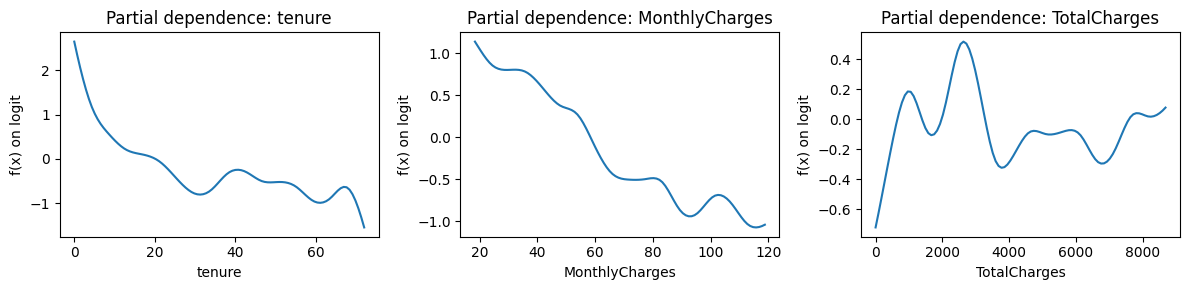

In [24]:
all_cols = list(X_train_scaled_df.columns)
pdp_terms = []
for t, term in enumerate(gam.terms):
    if getattr(term, "isintercept", False):
        continue
    if hasattr(term, "n_splines"):   # spline term
        pdp_terms.append((t, term))

n = len(pdp_terms)
plt.figure(figsize=(4*n, 3))

for j, (t, term) in enumerate(pdp_terms, 1):
    XX_scaled = gam.generate_X_grid(term=t)
    pdp = gam.partial_dependence(term=t, X=XX_scaled)

    feat_idx = term.feature
    feat_name = all_cols[feat_idx]

    if feat_name in cont_cols:
        raw_mean = scaler.mean_[cont_cols.index(feat_name)]
        raw_scale = scaler.scale_[cont_cols.index(feat_name)]
        x_raw = XX_scaled[:, feat_idx] * raw_scale + raw_mean
    else:
        x_raw = XX_scaled[:, feat_idx]

    plt.subplot(1, n, j)
    plt.plot(x_raw, pdp)
    plt.title(f"Partial dependence: {feat_name}")
    plt.xlabel(feat_name)
    plt.ylabel("f(x) on logit")

plt.tight_layout()
plt.show()


- **Correct link function(GAM summary)**

    - In logistic regression or GAM, the purpose of checking the link function is to ensure that the relationship between the response variable and the linear predictor is specified correctly.

    - For binary outcomes, GAMs typically use the combination of a Binomial distribution with a Logit link, which is the standard choice. In the model fit section, the GAM summary confirmed this specification with Distribution: BinomialDist and Link Function: LogitLink.

    - Therefore, this is considered an appropriate setup for churn prediction, and the logit link is also reasonable from the perspective of odds ratio interpretability and ease of explanation.

- **No multicollinearity: Same as (1)Linear Regression**

    - Multicollinearity is a data-level issue rather than individual model-specific, so it affects GAM just as it did in linear regression.

    - Since severe multicollinearity was already detected earlier, the same problem carries over to the GAM model.

**Summary**

- Key Interpretations
    - Tenure & TotalCharges (–, nonlinear): Longer tenure and higher cumulative charges reduce churn, with clear nonlinear patterns.
    - Fiber optic (+): Customers on fiber optic plans are more likely to churn.
    - Contract (One-/Two-year, –): Long-term contracts strongly protect against churn.
    - Electronic check (+): Customers paying via electronic check face higher churn risk.

- Limitations of GAM
    - Interpretation of spline shapes is less straightforward than odds ratios from logistic regression.

- Implications
    - GAM improves predictive power (Accuracy = 0.804 vs. 0.738) and calibration (Log Loss = 0.412 vs. 0.496) over logistic regression.
    - It captures nonlinear churn patterns missed by simpler models, making it the preferred approach here.
    - R^2 = 0.308 implies a better model fit relative to linear and logistic regression.

#### 5. Model Evaluation & Comparison

I have reviewed three models(Linear Regression, Logistic Regression, and Logistic GAM) and their required assumptions. Here, I compare their performance, interpretability, strengths and wekaness and provide recommendations for the telecommunications company's churn prediction strategy.

Linear Regression is inapproriate for binary churn classification, but useful to have intial insights. Logistic regression is interpretable with clear odds ration, but struggles to capture non-linear patterns. Lastly, Logistic GAM not only caputures non-linear effects but also maintains interpretability.

---
**Model Performance**

The performance comparison below is based on the test set for churn prediction. Linear Regression is not directly comparable to the classifier models (Logistic Regression and Logistic GAM), because it is fundamentally a regression model designed to predict continuous outcomes rather than discrete classes such as churn. Therefore, it is not suitable for this task.

*Note: Linear Regression metrics (R² = 0.261, MSE = 0.144) show a weak fit and are not directly comparable to classification metrics.*

| Model                   |  Accuracy |   ROC AUC |    PR AUC |    F1 |  Log Loss |
| ----------------------- | --------: | --------: | --------: | ----: | --------: |
| **Logistic Regression** |     0.738 |     0.842 |     0.633 | 0.614 |     0.496 |
| **GAM (LogisticGAM)**   | **0.804** | **0.848** | **0.667** | 0.591 | **0.412** |

When comparing the two classification models, Logistic GAM consistently outperforms Logistic Regression.
- ROC AUC / PR AUC: Both metrics are higher for GAM, indicating stronger ability to discriminate between churners and non-churners (ROC AUC) and better detection of the minority churn class (PR AUC).
- Accuracy: GAM (0.804) is higher than Logistic Regression (0.738), showing greater overall predictive correctness.
- Log Loss: GAM (0.412) is substantially lower than Logistic Regression (0.496), which means GAM’s predicted probabilities are closer to actual outcomes and therefore more reliable.
- F1 Score: Logistic Regression (0.614) is slightly higher than GAM (0.591). Since the F1 score reflects the balance between precision and recall at a fixed threshold, Logistic Regression may perform marginally better at that particular trade-off. However, this single metric is outweighed by GAM’s superiority across all other measures.

**Overall, Logistic GAM provides stronger predictive performance for customer churn prediction**

---
**Interpretability**

Overall, Logistic Regression offers the simplest and intuitive interpretability based on odds ratios, while Logistic GAM provides richer and more visual insights. In contrast, Linear Regression is not appropriate in this binary churn setting.

- Linear Regression: While mathematically transparent because coefficients directly represent direction and magnitude, interpretability is not appropriate in this binary churn setting. The model treats churn as a continuous outcome, which makes coefficient interpretation misleading.

- Logistic Regression: Provides clear and straightforward interpretability through odds ratios. For example, based on our analysis, fiber optic users are about 3.4 times more likely to churn than the reference group. Predictions can also be decomposed into log-odds contributions for each customer, showing how individual features increase or decrease churn risk. Therefore, Logistic Regression is best for simple and decision-maker-oriented interpretability.

- Logistic GAM: Goes beyond single-number odds ratios by showing how churn risk changes smoothly across the range of each variable. For example, in partial dependence plots, churn risk decreases steeply during the first few months of tenure, then stabilizes, while TotalCharges displays a nonlinear wavy pattern. These plots provide richer insights than simple odds ratios. Therefore, Logistic GAM is best for detailed interpretability, provided visualization is used.
---

**Weakness & Strengths**

- ***Linear Regression (OLS)***
    - Strengths
        - Simple and mathematically transparent using coefficiency
        - Coefficients directly indicate direction and magnitude of relationships.
        - Useful for exploratory analysis to identify initial signals.
    - Weaknesses
        - Not suitable for binary outcomes — treats churn as continuous, leading to misleading interpretations.
        - Low explanatory power (R^2 is 0.26).
        - Assumptions (linearity, homoscedasticity, normality) violated

- ***Logistic Regression***
    - Strengths
        - Stronger predictive performance than Linear Regression (Accuracy = 0.74, ROC AUC = 0.84).
        - Clear interpretability through odds ratios
        - Allows decomposition into feature contributions per customer.

    - Weaknesses
        - Linearity assumption violated (tenure, charges show nonlinearity).
        - Still less flexible in capturing complex churn dynamics compared to GAM.

- ***Logistic GAM***
    - Strengths
        - Inherits all strengths of Logistic Regression
        - Best predictive performance (Accuracy = 0.80, ROC AUC = 0.85).
        - Captures nonlinear patterns (tenure effects, TotalCharges waves).
        - Balances predictive accuracy and interpretability.
    - Weaknesses
        - Requires visualization for interpretability; less concise than odds ratios.
        - More complex to implement and explain compared to logistic regression.
---

**Recommendation**

After evaluating all three models, `Logistic GAM` is recommended as the most appropriate model for addressing the telecommunications company’s customer churn prediction. It outperforms both Linear and Logistic Regression in terms of predictive performance with higher accuracy and ROC AUC, while also providing better calibration of probabilities with less log loss. Unlike Logistic Regression, it flexibly captures underlying nonlinear patterns. It also retains an interpretable structure through smooth functions via partial dependent plot. These advantages make Logistic GAM the best balance between accuracy and interpretability, and its visual insights can directly inform targeted retention strategies to reduce customer churn.